In [1]:
!pip install fastai==2.0

     |████████████████████████████████| 350 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 189 kB 5.4 MB/s 


In [3]:
from fastai.vision.all import *

## Clasificación Multi-etiqueta

  - Predecir más de una etiqueta por imagen o incluso ninguna de las entrenadas

In [4]:
path = untar_data(URLs.PASCAL_2007)

In [ ]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/valid.json')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
len(df)

5011

In [ ]:
len(df[df.is_valid==False])

2501

In [ ]:
dblock = DataBlock()

In [ ]:
dsets = dblock.datasets(df)

In [ ]:
dsets.train[0]

(fname       001610.jpg
 labels             cat
 is_valid         False
 Name: 799, dtype: object, fname       001610.jpg
 labels             cat
 is_valid         False
 Name: 799, dtype: object)

In [ ]:
dsets.valid[0]

(fname       000156.jpg
 labels        sofa car
 is_valid          True
 Name: 76, dtype: object, fname       000156.jpg
 labels        sofa car
 is_valid          True
 Name: 76, dtype: object)

In [ ]:
## Se ha hecho una división aleatoria del df con un 20% (por defecto) para el
## conjunto de validación
len(dsets.train),len(dsets.valid) 

(4009, 1002)

In [ ]:
## En la tupla se repiten los valores. Es necesario seleccionar las columnas
## apropiadas del df. El primer valor de la tupla será el nombre de la imagen
## y el segundo valor la etiqueta
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('006950.jpg', 'person bicycle')

In [ ]:
## La variable independiente necesita la ruta completa para poder abrir las
## imágenes y la variable dependiente contiene listas de categorías delimitadas
## por espacios, por lo qe es necesario realizar un split
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split()
dblock = DataBlock(get_x= get_x, get_y= get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/009114.jpg'), ['horse', 'person'])

In [ ]:
## Para abrir la imagenes y transformarlas en tensores se utilizan un conjunto
## de transformaciones, block types. En esta ocasión se sustituye el
## CategoryBlock por MultiCategoryBlock para que devuelva varios enteros y en 
## lugar de uno. Representación one-hot encoding. No se puede usar una lista
## de índices de categorías porque tendrían diferente longitud y se requiren
## tensores de la misma longitud.
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x= get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['car']

In [ ]:
## División del df en train y validation meciante la columna 'is_valid'

TensorMultiCategory([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [6]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y,
                   splitter=splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [8]:
## Asegurar que todas las imágenes tienen el mismo tamaño con resize
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y,
                   splitter=splitter,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
## En pasos previos se ha venido utilizando el objeto datasets para validar los
## datos
dls = dblock.dataloaders(df)

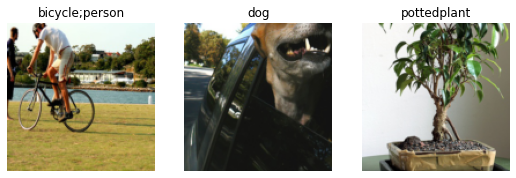

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
## Datos preparados para entrenar el modelo
## Es necesario cambiar la función de pérdida usada en capítulos anteriores
## (cross entropy loss) por binary cross entropy

Binary Cross Entropy

In [9]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

RuntimeError: ignored

In [11]:
torch.cuda.is_available()

True

In [15]:
## Los pesos no están en la GPU
learn.to("cuda")

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [17]:
activs[0]

TensorBase([ 2.2547, -3.7220, -0.4580, -0.6512, -3.5467, -0.0101,  1.8865, -2.5781,
         1.0385, -0.1371, -6.7502, -2.0570,  1.3693, -1.1448, -1.9668, -3.0854,
        -0.5810,  2.7735, -2.7420, -3.6710], device='cuda:0',
       grad_fn=<AliasBackward0>)

In [19]:
## Ya que la variable dependiente es one hot encoded, no se puede usar nll_loss
## ni softmax y por tanto no se puede usar cross entropy loss

### - softmax: Al poder tener múltiples objetos en una imagen no deben de sumar
###   1 ni menos de 1 si ninguna de las categorías aparece en la imagen. Además
###   tiende a hacer un valor mucho mas grande que otros por la exp.
### - nll_loss: Como solo devuelve el valor de una activación, no es apropiada
###   con múltiples etiquetas.

## Usar la función sigmoide
## En este caso cada categoría será tb un valor entre 0 y 1 pero no sumaran uno.
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [20]:
## Equivalencias en Pytorch y fastai para la función loss
# nn.BCELoss --> F.binary_cross_entropy, para one hot encoded target(no sigmoid)
# nn.BCEWithLogitsLoss --> F.binary_cross_entropy_with_logits (incluye sigmoid)
# nn.NLLLoss --> F.nll_loss, para single integer target (no incluye softmax)
# nn.CrossEntropyLoss --> F.cross_entropy (incluye softmax)

In [21]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0860, device='cuda:0', grad_fn=<AliasBackward0>)

In [22]:
## Por defecto, fastai infiere la función de loss a partir del DataLoaders, por
## lo que no sería necesario indicarsela en el entrenamiento.

In [24]:
## No se puede usar la métrica de capítulos anteriors por las multi-etiquetas.
## Esta función se quedará con la activación predicha mas grande (entero) e
## intentará comparar con una lista de enteros (one hot encoded)
def accuracy(inp, targ, axis=-1):
  "Compute accuracy with 'targ' when 'pred' is bs*n_classes"
  pred = inp.argmax(dim=axis)
  return (pred==targ).float().mean()

In [25]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  "Compute accuracy when 'inp' and 'targ' are the same size"
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [26]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.937893,0.697125,0.235737,00:45
1,0.823606,0.566153,0.284402,00:39
2,0.607525,0.206872,0.806016,00:39
3,0.362891,0.126297,0.937151,00:40


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133633,0.120454,0.941494,00:42
1,0.118079,0.108765,0.950120,00:42
2,0.097761,0.105618,0.952669,00:42


In [27]:
## Con un umbral demasiado pequeño, a menudo se fallará seleccionado objetos
## correctamente etiquetados
learn.metrics = partial(accuracy_multi, thresh=0.1)
## Devuelve validation loss y accuracy
learn.validate()

(#2) [0.1056177169084549,0.932350754737854]

In [28]:
## Con un umbral demasiado grande, solamente se seleccionaran los objetos de los
## que el modelo esté muy seguro
learn.metrics = partial(accuracy_multi, thresh=0.99)
## Devuelve validation loss y accuracy
learn.validate()

(#2) [0.1056177169084549,0.9439442157745361]

In [29]:
## Escoger el mejor threshold probando varios
## Guardando las predicciones es mucho más rápido
preds,targs = learn.get_preds()
## Por defecto, get_preds aplica la función sigmoide. Indicar que no se aplique
## en accuracy_multi
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9567)

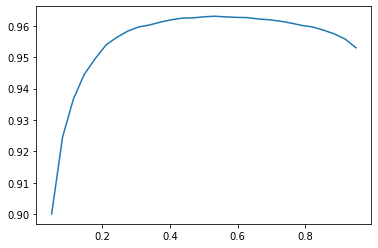

In [30]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

## Regresión
 - Las etiquetas son uno o varios números (cantidad en lugar de categoría)
 - Se puede realizar fácilmente como se venía haciendo con data block API

In [31]:
## Problema de regresión: modelo de puntos clave. Un punto clave es una
## localización espcífica en una imagen. Se usan imagenes de gente y se
## busca el centro de la cara de la persona en cada imagen, por tanto se
## predicen dos valores (fila y columna).

In [32]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [34]:
## Hay 24 directorios numerados del 01 al 24 (corresponden con las diferentes
## personas fotografiadas) y el correspondiente fichero .obj para cada uno 
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/16.obj'),Path('/root/.fastai/data/biwi_head_pose/21'),Path('/root/.fastai/data/biwi_head_pose/19'),Path('/root/.fastai/data/biwi_head_pose/10'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/03.obj'),Path('/root/.fastai/data/biwi_head_pose/20'),Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/22'),Path('/root/.fastai/data/biwi_head_pose/15.obj')...]

In [35]:
## Cada imagen dentro del directorio tiene asociado un archivo de pose .txt
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00143_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00404_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00433_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00222_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00097_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00190_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00056_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00157_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00497_rgb.jpg')...]

In [36]:
## Ensamblar los datos
## Asociar cada imagen con su correspondiente archivo .txt
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/21/frame_00533_pose.txt')

In [40]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

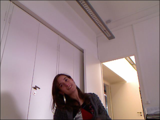

In [41]:
im.to_thumb(160)

In [53]:
## Extraer el punto central de la cabeza
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [55]:
## Esta función se va a usar como parámetro en DataBlock para etiquetar cada
## imagen
get_ctr(img_files[0])

tensor([285.4956, 326.8936])

In [61]:
## No se va a usar una división aleatoria porque la gente aparece en varias
## imágenes en el dataset y asegurar que el modelo generaliza bien con gente
## que no haya visto durante el entrenamiento.
## El bloque de la variable dependiente es PointBlock, de esta manera fastai
## reconoce que son coordenadas y tb que si se realiza data augmentation
## debe hacerla en la zona de las coordenadas.
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
          get_items=get_image_files,
          get_y= get_ctr,
          splitter=FuncSplitter(lambda o: o.parent.name=='13'),
          batch_tfms=[*aug_transforms(size=(240,320)),
                      Normalize.from_stats(*imagenet_stats)])

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


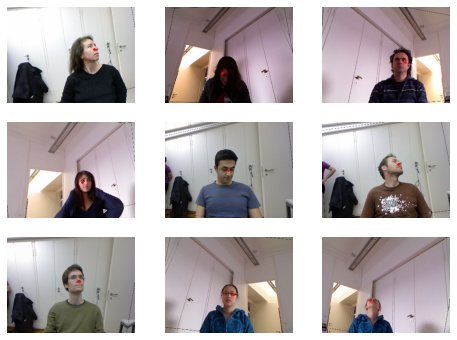

In [62]:
## Comprobación de los datos
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [63]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [64]:
yb[0]

TensorPoint([[0.0396, 0.3264]], device='cuda:0')

In [65]:
## Las coordenadas en Pytorch y fastai se reescalan siempre entre -1 y 1
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [66]:
## Por defecto ha cogido la función de loss apropiada
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0012022644514217973)

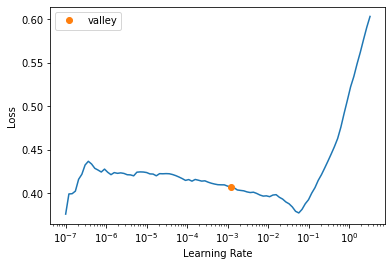

In [67]:
learn.lr_find()

In [68]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049392,0.051684,03:19


epoch,train_loss,valid_loss,time
0,0.007583,0.005764,03:16
1,0.002946,0.000749,03:00
2,0.001553,0.000425,02:59


In [69]:
## No es necesario especificar ninguna métrica ya que el Mean Squared Error
## es útil tb como métrica para esta tarea. Es más interpretable al hacer la
## raiz cuadrada
math.sqrt(0.0001)

0.01

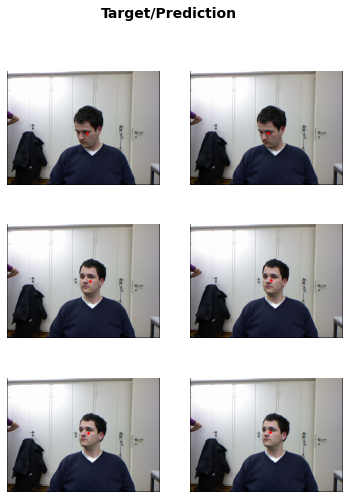

In [73]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

In [71]:
## Importante seleccionar la función de loss adecuada para cada tarea.
# - nnCrossEntropyLoss para Clasificación de etiqueta única
# - nn.BCEWithLogitsLoss para Clasificación multi-etiqueta
# - nn.MSELoss para regresión